In [17]:
import os
import torch
import pandas as pd
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torch.optim import lr_scheduler

from sklearn import model_selection
from sklearn import metrics
import transformers
import tokenizers
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup
from tqdm.autonotebook import tqdm
#import utils

from pathlib import Path

In [18]:
class config:
    MAX_LEN = 192
    TRAIN_BATCH_SIZE = 16
    VALID_BATCH_SIZE = 8
    #GRAD_ACC_STEPS = 1
    EPOCHS = 3 # 5 was useless, earlystopping kicked in
    LEARNING_RATE = 3e-5
    DATA_DIR = Path('')
    MODEL_NAME = "roberta-base"
    TRAINING_FILE = "train_folds_v2.csv"
    TOKENIZER = tokenizers.ByteLevelBPETokenizer( ##explore this
        vocab_file=f"vocab.json", 
        merges_file=f"merges.txt", 
        lowercase=True,
        add_prefix_space=True
    )

In [19]:
class TweetModel(transformers.BertPreTrainedModel):
    def __init__(self, conf):
        super(TweetModel, self).__init__(conf)
        self.roberta = transformers.RobertaModel.from_pretrained(config.MODEL_NAME, config=conf)
        self.drop_out = nn.Dropout(0.3)
        self.conv1d_128_0 = nn.Conv1d(768, 128, kernel_size=2, \
                           stride=1, padding=0, dilation=1, groups=1, \
                           bias=True, padding_mode='zeros')
        self.conv1d_128_1 = nn.Conv1d(768, 128, kernel_size=2, \
                           stride=1, padding=0, dilation=1, groups=1, \
                           bias=True, padding_mode='zeros')
        self.conv1d_64_0 = nn.Conv1d(128, 64, kernel_size=2, \
                           stride=1, padding=0, dilation=1, groups=1, \
                           bias=True, padding_mode='zeros')
        self.conv1d_64_1 = nn.Conv1d(128, 64, kernel_size=2, \
                           stride=1, padding=0, dilation=1, groups=1, \
                           bias=True, padding_mode='zeros')
        
        self.relu = nn.LeakyReLU()
        
        self.l0 = nn.Linear(64, 1)
        self.l1 = nn.Linear(64, 1)
        torch.nn.init.normal_(self.l0.weight, std=0.02)
        torch.nn.init.normal_(self.l1.weight, std=0.02)
        
        self.pad = nn.ConstantPad1d((0, 1), 0)
    
    def forward(self, ids, mask, token_type_ids):
        out, _ = self.roberta( #
            ids,
            attention_mask=mask,
            token_type_ids=token_type_ids
        )
        #out =  torch.cat((out[-1], out[-2]), dim=-1)
        out1 = out.permute(0, 2, 1)
        out1 = self.drop_out(out1)
        #print(out.shape)
        out1 = self.pad(out1)
        #print(out.shape)
        out1 = self.conv1d_128_0(out1)
        #print(out.shape)
        out1 = self.relu(out1)
        #print(out.shape)
        out1 = self.pad(out1)
        out1 = self.conv1d_64_0(out1)
        #print(out.shape)
        #out = out.flatten()
        out1 = out1.permute(0, 2, 1)
        #print(out.shape)
        start_logits = self.l0(out1)
        #print(logits.shape)
        
        #out =  torch.cat((out[-1], out[-2]), dim=-1)
        out2 = out.permute(0, 2, 1)
        out2 = self.drop_out(out2)
        #print(out.shape)
        out2 = self.pad(out2)
        #print(out.shape)
        out2 = self.conv1d_128_1(out2)
        #print(out.shape)
        out2 = self.relu(out2)
        #print(out.shape)
        out2 = self.pad(out2)
        out2 = self.conv1d_64_1(out2)
        #print(out.shape)
        #out = out.flatten()
        out2 = out2.permute(0, 2, 1)
        #print(out.shape)
        end_logits = self.l1(out2)
        #print(logits.shape)
        
        start_logits = start_logits.squeeze(-1)
        end_logits = end_logits.squeeze(-1)

        return start_logits, end_logits

In [20]:
def process_data(tweet, selected_text, sentiment, tokenizer, max_len):
    tweet = " " + " ".join(str(tweet).split())
    selected_text = " " + " ".join(str(selected_text).split())

    len_st = len(selected_text) - 1
    idx0 = None
    idx1 = None

    for ind in (i for i, e in enumerate(tweet) if e == selected_text[1]):
        if " " + tweet[ind: ind+len_st] == selected_text:
            idx0 = ind
            idx1 = ind + len_st - 1
            break

    char_targets = [0] * len(tweet)
    if idx0 != None and idx1 != None:
        for ct in range(idx0, idx1 + 1):
            char_targets[ct] = 1
    
    tok_tweet = tokenizer.encode(tweet)
    input_ids_orig = tok_tweet.ids
    tweet_offsets = tok_tweet.offsets
    
    target_idx = []
    for j, (offset1, offset2) in enumerate(tweet_offsets):
        if sum(char_targets[offset1: offset2]) > 0:
            target_idx.append(j)
    
    targets_start = target_idx[0]
    targets_end = target_idx[-1]

    sentiment_id = {
        'positive': 1313,
        'negative': 2430,
        'neutral': 7974
    }
    
    input_ids = [0] + [sentiment_id[sentiment]] + [2] + [2] + input_ids_orig + [2]
    token_type_ids = [0, 0, 0, 0] + [0] * (len(input_ids_orig) + 1)
    mask = [1] * len(token_type_ids)
    tweet_offsets = [(0, 0)] * 4 + tweet_offsets + [(0, 0)]
    targets_start += 4
    targets_end += 4

    padding_length = max_len - len(input_ids)
    if padding_length > 0:
        input_ids = input_ids + ([1] * padding_length)
        mask = mask + ([0] * padding_length)
        token_type_ids = token_type_ids + ([0] * padding_length)
        tweet_offsets = tweet_offsets + ([(0, 0)] * padding_length)
    
    return {
        'ids': input_ids,
        'mask': mask,
        'token_type_ids': token_type_ids,
        'targets_start': targets_start,
        'targets_end': targets_end,
        'orig_tweet': tweet,
        'orig_selected': selected_text,
        'sentiment': sentiment,
        'offsets': tweet_offsets
    }

In [21]:
class TweetDataset:
    def __init__(self, tweet, sentiment, selected_text):
        self.tweet = tweet
        self.sentiment = sentiment
        self.selected_text = selected_text
        self.tokenizer = config.TOKENIZER
        self.max_len = config.MAX_LEN
    
    def __len__(self):
        return len(self.tweet)

    def __getitem__(self, item):
        data = process_data(
            self.tweet[item], 
            self.selected_text[item], 
            self.sentiment[item],
            self.tokenizer,
            self.max_len
        )

        return {
            'ids': torch.tensor(data["ids"], dtype=torch.long),
            'mask': torch.tensor(data["mask"], dtype=torch.long),
            'token_type_ids': torch.tensor(data["token_type_ids"], dtype=torch.long),
            'targets_start': torch.tensor(data["targets_start"], dtype=torch.long),
            'targets_end': torch.tensor(data["targets_end"], dtype=torch.long),
            'orig_tweet': data["orig_tweet"],
            'orig_selected': data["orig_selected"],
            'sentiment': data["sentiment"],
            'offsets': torch.tensor(data["offsets"], dtype=torch.long)
        }


In [22]:
def calculate_jaccard_score(
    original_tweet, 
    target_string, 
    sentiment_val, 
    idx_start, 
    idx_end, 
    offsets,
    verbose=False):
    
    if idx_end < idx_start:
        idx_end = idx_start
    
    filtered_output  = ""
    for ix in range(idx_start, idx_end + 1):
        filtered_output += original_tweet[offsets[ix][0]: offsets[ix][1]]
        if (ix+1) < len(offsets) and offsets[ix][1] < offsets[ix+1][0]:
            filtered_output += " "

    if sentiment_val == "neutral" or len(original_tweet.split()) < 2:
        filtered_output = original_tweet

    jac = jaccard(target_string.strip(), filtered_output.strip())
    return jac, filtered_output

In [23]:
def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [24]:
class AverageMeter(object):
    """Computes and stores the average and current value.

    Examples::
        >>> # Initialize a meter to record loss
        >>> losses = AverageMeter()
        >>> # Update meter after every minibatch update
        >>> losses.update(loss_value, batch_size)
    """

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [25]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model, model_path):

        score = val_loss#-val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model, model_path)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model, model_path)
            self.counter = 0

    def save_checkpoint(self, val_loss, model, model_path):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), model_path)
        self.val_loss_min = val_loss

In [26]:
def loss_fn(logits, positions):
    start_logits, end_logits = logits
    start_positions, end_positions = positions
    loss_fct = nn.CrossEntropyLoss()
    start_loss = loss_fct(start_logits, start_positions)
    end_loss = loss_fct(end_logits, end_positions)
    total_loss = (start_loss + end_loss)
    return total_loss

In [27]:
def train_fn(data_loader, model, optimizer, device, scheduler=None):
    model.train()
    losses = AverageMeter()
    jaccards = AverageMeter()

    tk0 = tqdm(data_loader, total=len(data_loader))
    
    for bi, d in enumerate(tk0):

        ids = d["ids"]
        token_type_ids = d["token_type_ids"]
        mask = d["mask"]
        targets_start = d["targets_start"]
        targets_end = d["targets_end"]
        sentiment = d["sentiment"]
        orig_selected = d["orig_selected"]
        orig_tweet = d["orig_tweet"]
        targets_start = d["targets_start"]
        targets_end = d["targets_end"]
        offsets = d["offsets"]

        ids = ids.to(device, dtype=torch.long)
        token_type_ids = token_type_ids.to(device, dtype=torch.long)
        mask = mask.to(device, dtype=torch.long)
        targets_start = targets_start.to(device, dtype=torch.long)
        targets_end = targets_end.to(device, dtype=torch.long)

        model.zero_grad()
        outputs_start, outputs_end = model(
            ids=ids,
            mask=mask,
            token_type_ids=token_type_ids,
        )
        loss = loss_fn(outputs_start, outputs_end, targets_start, targets_end)
        loss = loss #/ config.GRAD_ACC_STEPS
        loss.backward()
        optimizer.step()
        scheduler.step()

        outputs_start = torch.softmax(outputs_start, dim=1).cpu().detach().numpy()
        outputs_end = torch.softmax(outputs_end, dim=1).cpu().detach().numpy()
        jaccard_scores = []
        for px, tweet in enumerate(orig_tweet):
            selected_tweet = orig_selected[px]
            tweet_sentiment = sentiment[px]
            jaccard_score, _ = calculate_jaccard_score(
                original_tweet=tweet,
                target_string=selected_tweet,
                sentiment_val=tweet_sentiment,
                idx_start=np.argmax(outputs_start[px, :]),
                idx_end=np.argmax(outputs_end[px, :]),
                offsets=offsets[px]
            )
            jaccard_scores.append(jaccard_score)

        jaccards.update(np.mean(jaccard_scores), ids.size(0))
        losses.update(loss.item(), ids.size(0))
        tk0.set_postfix(loss=losses.avg, jaccard=jaccards.avg)

In [28]:
# def eval_fn(data_loader, model, device):
#     model.eval()
#     losses = AverageMeter()
#     jaccards = AverageMeter()
    
#     with torch.no_grad():
#         tk0 = tqdm(data_loader, total=len(data_loader))
#         for bi, d in enumerate(tk0):
#             ids = d["ids"]
#             token_type_ids = d["token_type_ids"]
#             mask = d["mask"]
#             sentiment = d["sentiment"]
#             orig_selected = d["orig_selected"]
#             orig_tweet = d["orig_tweet"]
#             targets_start = d["targets_start"]
#             targets_end = d["targets_end"]
#             offsets = d["offsets"].numpy()

#             ids = ids.to(device, dtype=torch.long)
#             token_type_ids = token_type_ids.to(device, dtype=torch.long)
#             mask = mask.to(device, dtype=torch.long)
#             targets_start = targets_start.to(device, dtype=torch.long)
#             targets_end = targets_end.to(device, dtype=torch.long)

#             outputs_start, outputs_end = model(
#                 ids=ids,
#                 mask=mask,
#                 token_type_ids=token_type_ids
#             )
#             loss = loss_fn(outputs_start, outputs_end, targets_start, targets_end)
#             outputs_start = torch.softmax(outputs_start, dim=1).cpu().detach().numpy()
#             outputs_end = torch.softmax(outputs_end, dim=1).cpu().detach().numpy()
#             jaccard_scores = []
#             for px, tweet in enumerate(orig_tweet):
#                 selected_tweet = orig_selected[px]
#                 tweet_sentiment = sentiment[px]
#                 jaccard_score, _ = calculate_jaccard_score(
#                     original_tweet=tweet,
#                     target_string=selected_tweet,
#                     sentiment_val=tweet_sentiment,
#                     idx_start=np.argmax(outputs_start[px, :]),
#                     idx_end=np.argmax(outputs_end[px, :]),
#                     offsets=offsets[px]
#                 )
#                 jaccard_scores.append(jaccard_score)

#             jaccards.update(np.mean(jaccard_scores), ids.size(0))
#             losses.update(loss.item(), ids.size(0))
#             tk0.set_postfix(loss=losses.avg, jaccard=jaccards.avg)
    
#     print(f"Jaccard = {jaccards.avg}")
#     return jaccards.avg

In [29]:
# def run(fold):
#     dfx = pd.read_csv(config.TRAINING_FILE)

#     df_train = dfx[dfx.kfold != fold].reset_index(drop=True)
#     df_valid = dfx[dfx.kfold == fold].reset_index(drop=True)
# #     df_train = df_train.head(100)
# #     df_valid = df_train
# #     #
    
#     train_dataset = TweetDataset(
#         tweet=df_train.text.values,
#         sentiment=df_train.sentiment.values,
#         selected_text=df_train.selected_text.values
#     )

#     train_data_loader = torch.utils.data.DataLoader(
#         train_dataset,
#         batch_size=config.TRAIN_BATCH_SIZE,
#         num_workers=4
#     )

#     valid_dataset = TweetDataset(
#         tweet=df_valid.text.values,
#         sentiment=df_valid.sentiment.values,
#         selected_text=df_valid.selected_text.values
#     )

#     valid_data_loader = torch.utils.data.DataLoader(
#         valid_dataset,
#         batch_size=config.VALID_BATCH_SIZE,
#         num_workers=2
#     )

#     device = torch.device("cuda")
#     model_config = transformers.RobertaConfig.from_pretrained(config.MODEL_NAME)
#     #model_config.output_hidden_states = True
#     model = TweetModel(conf=model_config)
#     model.to(device)

#     num_train_steps = int(len(df_train) / config.TRAIN_BATCH_SIZE * config.EPOCHS)
#     param_optimizer = list(model.named_parameters())
#     no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
#     optimizer_parameters = [
#         {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
#         {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0},
#     ]
#     optimizer = AdamW(optimizer_parameters, lr=config.LEARNING_RATE)
#     scheduler = get_linear_schedule_with_warmup(
#         optimizer, 
#         num_warmup_steps=0, 
#         num_training_steps=num_train_steps
#     )

#     es = EarlyStopping(patience=100)#, mode="max")
#     print(f"Training is Starting for fold={fold}")
    
#     # I'm training only for 3 epochs even though I specified 5!!!
#     for epoch in range(config.EPOCHS):
#         train_fn(train_data_loader, model, optimizer, device, scheduler=scheduler)
#         jaccard = eval_fn(valid_data_loader, model, device)
#         print(f"Jaccard Score = {jaccard}")
#         es(jaccard, model, model_path=f"model_{fold}-exp3.bin")
#         if es.early_stop:
#             print("Early stopping")
#             break

In [30]:
import copy
import os
import torch
from tqdm.autonotebook import tqdm
from torch.optim.lr_scheduler import _LRScheduler
import matplotlib.pyplot as plt

try:
    from apex import amp

    IS_AMP_AVAILABLE = True
except ImportError:
    import logging

    logging.basicConfig()
    logger = logging.getLogger(__name__)
    logger.warning(
        "To enable mixed precision training, please install `apex`. "
        "Or you can re-install this package by the following command:\n"
        '  pip install torch-lr-finder -v --global-option="amp"'
    )
    IS_AMP_AVAILABLE = False
    del logging


class LRFinder(object):
    """Learning rate range test.
    The learning rate range test increases the learning rate in a pre-training run
    between two boundaries in a linear or exponential manner. It provides valuable
    information on how well the network can be trained over a range of learning rates
    and what is the optimal learning rate.
    Arguments:
        model (torch.nn.Module): wrapped model.
        optimizer (torch.optim.Optimizer): wrapped optimizer where the defined learning
            is assumed to be the lower boundary of the range test.
        criterion (torch.nn.Module): wrapped loss function.
        device (str or torch.device, optional): a string ("cpu" or "cuda") with an
            optional ordinal for the device type (e.g. "cuda:X", where is the ordinal).
            Alternatively, can be an object representing the device on which the
            computation will take place. Default: None, uses the same device as `model`.
        memory_cache (boolean, optional): if this flag is set to True, `state_dict` of
            model and optimizer will be cached in memory. Otherwise, they will be saved
            to files under the `cache_dir`.
        cache_dir (string, optional): path for storing temporary files. If no path is
            specified, system-wide temporary directory is used. Notice that this
            parameter will be ignored if `memory_cache` is True.
    Example:
        >>> lr_finder = LRFinder(net, optimizer, criterion, device="cuda")
        >>> lr_finder.range_test(dataloader, end_lr=100, num_iter=100)
        >>> lr_finder.plot() # to inspect the loss-learning rate graph
        >>> lr_finder.reset() # to reset the model and optimizer to their initial state
    Reference:
    Cyclical Learning Rates for Training Neural Networks: https://arxiv.org/abs/1506.01186
    fastai/lr_find: https://github.com/fastai/fastai
    """

    def __init__(
        self,
        model,
        optimizer,
        criterion,
        device=None,
        memory_cache=True,
        cache_dir=None,
    ):
        # Check if the optimizer is already attached to a scheduler
        self.optimizer = optimizer
        self._check_for_scheduler()

        self.model = model
        self.criterion = criterion
        self.history = {"lr": [], "loss": []}
        self.best_loss = None
        self.memory_cache = memory_cache
        self.cache_dir = cache_dir

        # Save the original state of the model and optimizer so they can be restored if
        # needed
        self.model_device = next(self.model.parameters()).device
        self.state_cacher = StateCacher(memory_cache, cache_dir=cache_dir)
        self.state_cacher.store("model", self.model.state_dict())
        self.state_cacher.store("optimizer", self.optimizer.state_dict())

        # If device is None, use the same as the model
        if device:
            self.device = device
        else:
            self.device = self.model_device

    def reset(self):
        """Restores the model and optimizer to their initial states."""

        self.model.load_state_dict(self.state_cacher.retrieve("model"))
        self.optimizer.load_state_dict(self.state_cacher.retrieve("optimizer"))
        self.model.to(self.model_device)

    def range_test(
        self,
        train_loader,
        val_loader=None,
        start_lr=None,
        end_lr=10,
        num_iter=100,
        step_mode="exp",
        smooth_f=0.05,
        diverge_th=5,
        accumulation_steps=1,
    ):
        """Performs the learning rate range test.
        Arguments:
            train_loader (torch.utils.data.DataLoader): the training set data laoder.
            val_loader (torch.utils.data.DataLoader, optional): if `None` the range test
                will only use the training loss. When given a data loader, the model is
                evaluated after each iteration on that dataset and the evaluation loss
                is used. Note that in this mode the test takes significantly longer but
                generally produces more precise results. Default: None.
            start_lr (float, optional): the starting learning rate for the range test.
                Default: None (uses the learning rate from the optimizer).
            end_lr (float, optional): the maximum learning rate to test. Default: 10.
            num_iter (int, optional): the number of iterations over which the test
                occurs. Default: 100.
            step_mode (str, optional): one of the available learning rate policies,
                linear or exponential ("linear", "exp"). Default: "exp".
            smooth_f (float, optional): the loss smoothing factor within the [0, 1[
                interval. Disabled if set to 0, otherwise the loss is smoothed using
                exponential smoothing. Default: 0.05.
            diverge_th (int, optional): the test is stopped when the loss surpasses the
                threshold:  diverge_th * best_loss. Default: 5.
            accumulation_steps (int, optional): steps for gradient accumulation. If it
                is 1, gradients are not accumulated. Default: 1.
        Example (fastai approach):
            >>> lr_finder = LRFinder(net, optimizer, criterion, device="cuda")
            >>> lr_finder.range_test(dataloader, end_lr=100, num_iter=100)
        Example (Leslie Smith's approach):
            >>> lr_finder = LRFinder(net, optimizer, criterion, device="cuda")
            >>> lr_finder.range_test(trainloader, val_loader=val_loader, end_lr=1, num_iter=100, step_mode="linear")
        Gradient accumulation is supported; example:
            >>> train_data = ...    # prepared dataset
            >>> desired_bs, real_bs = 32, 4         # batch size
            >>> accumulation_steps = desired_bs // real_bs     # required steps for accumulation
            >>> dataloader = torch.utils.data.DataLoader(train_data, batch_size=real_bs, shuffle=True)
            >>> acc_lr_finder = LRFinder(net, optimizer, criterion, device="cuda")
            >>> acc_lr_finder.range_test(dataloader, end_lr=10, num_iter=100, accumulation_steps=accumulation_steps)
        Reference:
        [Training Neural Nets on Larger Batches: Practical Tips for 1-GPU, Multi-GPU & Distributed setups](
        https://medium.com/huggingface/ec88c3e51255)
        [thomwolf/gradient_accumulation](https://gist.github.com/thomwolf/ac7a7da6b1888c2eeac8ac8b9b05d3d3)
        """

        # Reset test results
        self.history = {"lr": [], "loss": []}
        self.best_loss = None

        # Move the model to the proper device
        self.model.to(self.device)

        # Check if the optimizer is already attached to a scheduler
        self._check_for_scheduler()

        # Set the starting learning rate
        if start_lr:
            self._set_learning_rate(start_lr)

        # Initialize the proper learning rate policy
        if step_mode.lower() == "exp":
            lr_schedule = ExponentialLR(self.optimizer, end_lr, num_iter)
        elif step_mode.lower() == "linear":
            lr_schedule = LinearLR(self.optimizer, end_lr, num_iter)
        else:
            raise ValueError("expected one of (exp, linear), got {}".format(step_mode))

        if smooth_f < 0 or smooth_f >= 1:
            raise ValueError("smooth_f is outside the range [0, 1[")

        # Create an iterator to get data batch by batch
        iter_wrapper = DataLoaderIterWrapper(train_loader)
        for iteration in tqdm(range(num_iter)):
            # Train on batch and retrieve loss
            loss = self._train_batch(iter_wrapper, accumulation_steps)
            if val_loader:
                loss = self._validate(val_loader)

            # Update the learning rate
            lr_schedule.step()
            self.history["lr"].append(lr_schedule.get_lr()[0])

            # Track the best loss and smooth it if smooth_f is specified
            if iteration == 0:
                self.best_loss = loss
            else:
                if smooth_f > 0:
                    loss = smooth_f * loss + (1 - smooth_f) * self.history["loss"][-1]
                if loss < self.best_loss:
                    self.best_loss = loss

            # Check if the loss has diverged; if it has, stop the test
            self.history["loss"].append(loss)
            if loss > diverge_th * self.best_loss:
                print("Stopping early, the loss has diverged")
                break

        print("Learning rate search finished. See the graph with {finder_name}.plot()")

    def _set_learning_rate(self, new_lrs):
        if not isinstance(new_lrs, list):
            new_lrs = [new_lrs] * len(self.optimizer.param_groups)
        if len(new_lrs) != len(self.optimizer.param_groups):
            raise ValueError(
                "Length of `new_lrs` is not equal to the number of parameter groups "
                + "in the given optimizer"
            )

        for param_group, new_lr in zip(self.optimizer.param_groups, new_lrs):
            param_group["lr"] = new_lr

    def _check_for_scheduler(self):
        for param_group in self.optimizer.param_groups:
            if "initial_lr" in param_group:
                raise RuntimeError("Optimizer already has a scheduler attached to it")

    def _train_batch(self, iter_wrapper, accumulation_steps):
        self.model.train()
        total_loss = None  # for late initialization

        self.optimizer.zero_grad()
        for i in range(accumulation_steps):
            
            d = next(iter_wrapper)
            device = 'cuda'
            ids = d["ids"]
            token_type_ids = d["token_type_ids"]
            mask = d["mask"]
            targets_start = d["targets_start"]
            targets_end = d["targets_end"]
            sentiment = d["sentiment"]
            orig_selected = d["orig_selected"]
            orig_tweet = d["orig_tweet"]
            targets_start = d["targets_start"]
            targets_end = d["targets_end"]
            offsets = d["offsets"]
            ids = ids.to(device, dtype=torch.long)
            token_type_ids = token_type_ids.to(device, dtype=torch.long)
            mask = mask.to(device, dtype=torch.long)
            targets_start = targets_start.to(device, dtype=torch.long)
            targets_end = targets_end.to(device, dtype=torch.long)
            
            labels = (targets_start, targets_end)
            
            #inputs, labels = self._move_to_device(inputs, labels)
            # Forward pass
            outputs = self.model(
                ids=ids,
                mask=mask,
                token_type_ids=token_type_ids
            )
            loss = self.criterion(outputs, labels)

            # Loss should be averaged in each step
            loss /= accumulation_steps

            # Backward pass
            if IS_AMP_AVAILABLE and hasattr(self.optimizer, "_amp_stash"):
                # For minor performance optimization, see also:
                # https://nvidia.github.io/apex/advanced.html#gradient-accumulation-across-iterations
                delay_unscale = ((i + 1) % accumulation_steps) != 0

                with amp.scale_loss(
                    loss, self.optimizer, delay_unscale=delay_unscale
                ) as scaled_loss:
                    scaled_loss.backward()
            else:
                loss.backward()

            if total_loss is None:
                total_loss = loss
            else:
                total_loss += loss

        self.optimizer.step()

        return total_loss.item()

    def _move_to_device(self, inputs, labels):
        def move(obj, device):
            if hasattr(obj, "to"):
                return obj.to(device)
            elif isinstance(obj, tuple):
                return tuple(move(o, device) for o in obj)
            elif isinstance(obj, list):
                return [move(o, device) for o in obj]
            elif isinstance(obj, dict):
                return {k: move(o, device) for k, o in obj.items()}
            else:
                return obj

        inputs = move(inputs, self.device)
        labels = move(labels, self.device)
        return inputs, labels

    def _validate(self, dataloader):
        # Set model to evaluation mode and disable gradient computation
        running_loss = 0
        self.model.eval()
        with torch.no_grad():
            for d in dataloader:
                
                device = 'cuda'
                ids = d["ids"]
                token_type_ids = d["token_type_ids"]
                mask = d["mask"]
                sentiment = d["sentiment"]
                orig_selected = d["orig_selected"]
                orig_tweet = d["orig_tweet"]
                targets_start = d["targets_start"]
                targets_end = d["targets_end"]
                offsets = d["offsets"].numpy()
                ids = ids.to(device, dtype=torch.long)
                token_type_ids = token_type_ids.to(device, dtype=torch.long)
                mask = mask.to(device, dtype=torch.long)
                targets_start = targets_start.to(device, dtype=torch.long)
                targets_end = targets_end.to(device, dtype=torch.long)
            
                # Move data to the correct device
                #inputs, labels = self._move_to_device(inputs, labels)

                if isinstance(inputs, tuple) or isinstance(inputs, list):
                    batch_size = inputs[0].size(0)
                else:
                    batch_size = inputs.size(0)

                # Forward pass and loss computation
                outputs = self.model(
                ids=ids,
                mask=mask,
                token_type_ids=token_type_ids
            )
                loss = self.criterion(outputs, labels)
                running_loss += loss.item() * batch_size

        return running_loss / len(dataloader.dataset)

    def plot(self, skip_start=10, skip_end=5, log_lr=True, show_lr=None, ax=None):
        """Plots the learning rate range test.
        Arguments:
            skip_start (int, optional): number of batches to trim from the start.
                Default: 10.
            skip_end (int, optional): number of batches to trim from the start.
                Default: 5.
            log_lr (bool, optional): True to plot the learning rate in a logarithmic
                scale; otherwise, plotted in a linear scale. Default: True.
            show_lr (float, optional): if set, adds a vertical line to visualize the
                specified learning rate. Default: None.
            ax (matplotlib.axes.Axes, optional): the plot is created in the specified
                matplotlib axes object and the figure is not be shown. If `None`, then
                the figure and axes object are created in this method and the figure is
                shown . Default: None.
        Returns:
            The matplotlib.axes.Axes object that contains the plot.
        """

        if skip_start < 0:
            raise ValueError("skip_start cannot be negative")
        if skip_end < 0:
            raise ValueError("skip_end cannot be negative")
        if show_lr is not None and not isinstance(show_lr, float):
            raise ValueError("show_lr must be float")

        # Get the data to plot from the history dictionary. Also, handle skip_end=0
        # properly so the behaviour is the expected
        lrs = self.history["lr"]
        losses = self.history["loss"]
        if skip_end == 0:
            lrs = lrs[skip_start:]
            losses = losses[skip_start:]
        else:
            lrs = lrs[skip_start:-skip_end]
            losses = losses[skip_start:-skip_end]

        # Create the figure and axes object if axes was not already given
        fig = None
        if ax is None:
            fig, ax = plt.subplots()

        # Plot loss as a function of the learning rate
        ax.plot(lrs, losses)
        if log_lr:
            ax.set_xscale("log")
        ax.set_xlabel("Learning rate")
        ax.set_ylabel("Loss")

        if show_lr is not None:
            ax.axvline(x=show_lr, color="red")

        # Show only if the figure was created internally
        if fig is not None:
            plt.show()

        return ax


class LinearLR(_LRScheduler):
    """Linearly increases the learning rate between two boundaries over a number of
    iterations.
    Arguments:
        optimizer (torch.optim.Optimizer): wrapped optimizer.
        end_lr (float): the final learning rate.
        num_iter (int): the number of iterations over which the test occurs.
        last_epoch (int, optional): the index of last epoch. Default: -1.
    """

    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr
        self.num_iter = num_iter
        super(LinearLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        curr_iter = self.last_epoch + 1
        r = curr_iter / self.num_iter
        return [base_lr + r * (self.end_lr - base_lr) for base_lr in self.base_lrs]


class ExponentialLR(_LRScheduler):
    """Exponentially increases the learning rate between two boundaries over a number of
    iterations.
    Arguments:
        optimizer (torch.optim.Optimizer): wrapped optimizer.
        end_lr (float): the final learning rate.
        num_iter (int): the number of iterations over which the test occurs.
        last_epoch (int, optional): the index of last epoch. Default: -1.
    """

    def __init__(self, optimizer, end_lr, num_iter, last_epoch=-1):
        self.end_lr = end_lr
        self.num_iter = num_iter
        super(ExponentialLR, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        curr_iter = self.last_epoch + 1
        r = curr_iter / self.num_iter
        return [base_lr * (self.end_lr / base_lr) ** r for base_lr in self.base_lrs]


class StateCacher(object):
    def __init__(self, in_memory, cache_dir=None):
        self.in_memory = in_memory
        self.cache_dir = cache_dir

        if self.cache_dir is None:
            import tempfile

            self.cache_dir = tempfile.gettempdir()
        else:
            if not os.path.isdir(self.cache_dir):
                raise ValueError("Given `cache_dir` is not a valid directory.")

        self.cached = {}

    def store(self, key, state_dict):
        if self.in_memory:
            self.cached.update({key: copy.deepcopy(state_dict)})
        else:
            fn = os.path.join(self.cache_dir, "state_{}_{}.pt".format(key, id(self)))
            self.cached.update({key: fn})
            torch.save(state_dict, fn)

    def retrieve(self, key):
        if key not in self.cached:
            raise KeyError("Target {} was not cached.".format(key))

        if self.in_memory:
            return self.cached.get(key)
        else:
            fn = self.cached.get(key)
            if not os.path.exists(fn):
                raise RuntimeError(
                    "Failed to load state in {}. File doesn't exist anymore.".format(fn)
                )
            state_dict = torch.load(fn, map_location=lambda storage, location: storage)
            return state_dict

    def __del__(self):
        """Check whether there are unused cached files existing in `cache_dir` before
        this instance being destroyed."""

        if self.in_memory:
            return

        for k in self.cached:
            if os.path.exists(self.cached[k]):
                os.remove(self.cached[k])


class DataLoaderIterWrapper(object):
    """A wrapper for iterating `torch.utils.data.DataLoader` with the ability to reset
    itself while `StopIteration` is raised."""

    def __init__(self, data_loader, auto_reset=True):
        self.data_loader = data_loader
        self.auto_reset = auto_reset
        self._iterator = iter(data_loader)

    def __next__(self):
        # Get a new set of inputs and labels
        try:
            d = next(self._iterator)
        except StopIteration:
            if not self.auto_reset:
                raise
            self._iterator = iter(self.data_loader)
            d = next(self._iterator)

        return d

In [31]:
def test_lr():
    dfx = pd.read_csv(config.TRAINING_FILE)

    fold = 0
    df_train = dfx[dfx.kfold != fold].reset_index(drop=True)
    df_valid = dfx[dfx.kfold == fold].reset_index(drop=True)

    
    train_dataset = TweetDataset(
        tweet=df_train.text.values,
        sentiment=df_train.sentiment.values,
        selected_text=df_train.selected_text.values
    )

    train_data_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=config.TRAIN_BATCH_SIZE,
        num_workers=4
    )
        
    device = torch.device("cuda")
    model_config = transformers.RobertaConfig.from_pretrained(config.MODEL_NAME)
    #model_config.output_hidden_states = True
    model = TweetModel(conf=model_config)
    model.to(device)
    
    num_train_steps = int(len(df_train) / config.TRAIN_BATCH_SIZE * config.EPOCHS)
    param_optimizer = list(model.named_parameters())
    no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
    optimizer_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0},
    ]
    optimizer = AdamW(optimizer_parameters, lr=1e-7)

    
    criterion = loss_fn
    
    lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
    lr_finder.range_test(train_data_loader, end_lr=0.01, num_iter=1000)
    lr_finder.plot() # to inspect the loss-learning rate graph
    lr_finder.reset() # to reset the model and optimizer to their initial state


Learning rate search finished. See the graph with {finder_name}.plot()


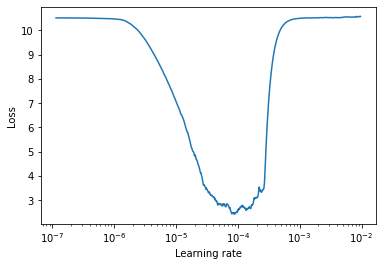

In [33]:
test_lr()